In [88]:
from sqlalchemy import create_engine,text
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import boxcox

In [89]:
from dotenv import load_dotenv
import os
load_dotenv()
user=os.getenv("USER")
password=os.getenv("PASSWORD")
host=os.getenv("HOST")
port=os.getenv("PORT")
schema=os.getenv("SCHEMA")

In [90]:
engine = create_engine(f"oracle+oracledb://{user}:{password}@{host}:{port}/oracle?mode={schema}")

In [91]:
with engine.connect() as conn:
    query=text("select * from heart_disease")
    df=pd.read_sql(query,conn)

In [92]:
df.head()

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,1,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,2,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,3,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,4,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,5,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        303 non-null    int64  
 1   age       303 non-null    int64  
 2   sex       303 non-null    int64  
 3   cp        303 non-null    int64  
 4   trestbps  303 non-null    int64  
 5   chol      303 non-null    int64  
 6   fbs       303 non-null    int64  
 7   restecg   303 non-null    int64  
 8   thalach   303 non-null    int64  
 9   exang     303 non-null    int64  
 10  oldpeak   303 non-null    float64
 11  slope     303 non-null    int64  
 12  ca        303 non-null    int64  
 13  thal      303 non-null    int64  
 14  target    303 non-null    int64  
dtypes: float64(1), int64(14)
memory usage: 35.6 KB


# Data Dictionary

1. age: age in years

2. sex: sex
1 = male
0 = female
3. cp: chest pain type
Value 0: typical angina
Value 1: atypical angina
Value 2: non-anginal pain
Value 3: asymptomatic
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
5. chol: serum cholestoral in mg/dl
6. fbs: (fasting blood sugar > 120 mg/dl)
1 = true;
0 = false
7. restecg: resting electrocardiographic results
Value 0: normal
Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina
1 = yes
0 = no
10. oldpeak = ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
Value 0: upsloping
Value 1: flat
Value 2: downsloping
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal:
0 = error (in the original dataset 0 maps to NaN's)
1 = fixed defect
2 = normal
3 = reversable defect
14. target (the lable):
0 = no disease,
1 = disease

In [94]:
## renaming columns for better understanding

df = df.rename(
    columns = {'cp':'chest_pain_type', 
               'trestbps':'resting_blood_pressure', 
               'chol': 'cholesterol',
               'fbs': 'fasting_blood_sugar',
               'restecg' : 'resting_electrocardiogram', 
               'thalach': 'max_heart_rate_achieved', 
               'exang': 'exercise_induced_angina',
               'oldpeak': 'st_depression', 
               'slope': 'st_slope', 
               'ca':'num_major_vessels', 
               'thal': 'thalassemia'}, 
    errors="raise")

Based on the data types and the feature explanations we had earlier, we can see that 9 columns (sex, cp, fbs, restecg, exang, slope, ca, thal, and target) are indeed numerical in terms of data type, but categorical in terms of their semantics. These features should be converted to string (object) data type for proper analysis and interpretation

In [95]:
#dropping id as it is only sequencial 
df.drop("id",axis=1,inplace=True)

In [96]:
# Define the continuous features
continuous_features = ['age', 'resting_blood_pressure', 'cholesterol', 'max_heart_rate_achieved', 'st_depression']

features_to_convert= [col for col in df.columns if col not in  continuous_features]

df[features_to_convert]=df[features_to_convert].astype("object")

In [97]:
df.dtypes

age                            int64
sex                           object
chest_pain_type               object
resting_blood_pressure         int64
cholesterol                    int64
fasting_blood_sugar           object
resting_electrocardiogram     object
max_heart_rate_achieved        int64
exercise_induced_angina       object
st_depression                float64
st_slope                      object
num_major_vessels             object
thalassemia                   object
target                        object
dtype: object

In [98]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
resting_blood_pressure,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
cholesterol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
max_heart_rate_achieved,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
st_depression,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


1. age: The average age of the patients is approximately 54.4 years, with the youngest being 29 and the oldest 77 years.
2. resting_blood_pressure: The average resting blood pressure is about 131.62 mm Hg, ranging from 94 to 200 mm Hg.
3. cholesterol: The average cholesterol level is approximately 246.26 mg/dl, with a minimum of 126 and a maximum of 564 mg/dl.
4. max_heart_rate_achieved: The average maximum heart rate achieved is around 149.65, with a range from 71 to 202.
5. st_depression: The average ST depression induced by exercise relative to rest is about 1.04, with values ranging from 0 to 6.2.

In [99]:
df.describe(include="object")

,sex,chest_pain_type,fasting_blood_sugar,resting_electrocardiogram,exercise_induced_angina,st_slope,num_major_vessels,thalassemia,target
count,303,303,303,303,303,303,303,303,303
unique,2,4,2,3,2,3,5,4,2
top,1,0,0,1,0,2,0,2,1
freq,207,143,258,152,204,142,175,166,165


- sex: There are two unique values, with males (denoted as 0) being the most frequent category, occurring 207 times out of 303 entries.
- chest_pain_type: Four unique types of chest pain are present. The most common type is "0", occurring 143 times.
- fasting_blood_sugar: There are two categories, and the most frequent one is "0" (indicating fasting blood sugar less than 120 mg/dl), which appears 258 times.
- resting_electrocardiogram: Three unique results are present. The most common result is "1", appearing 152 times.
- exercise_induced_angina: There are two unique values. The most frequent value is "0" (indicating no exercise-induced angina), which is observed 204 times.
- st_slope: Three unique slopes are present. The most frequent slope type is "2", which occurs 142 times.
- num_major_vessels: There are five unique values for the number of major vessels colored by fluoroscopy, with "0" being the most frequent, occurring 175 times.
- thalassemia: Four unique results are available. The most common type is "2" (indicating a reversible defect), observed 166 times.
- target: Two unique values indicate the presence or absence of heart disease. The value "1" (indicating the presence of heart disease) is the most frequent, observed in 165 entries.

# EDA

### Univariate Analysis

##### Numerical Variables Univariate Analysis

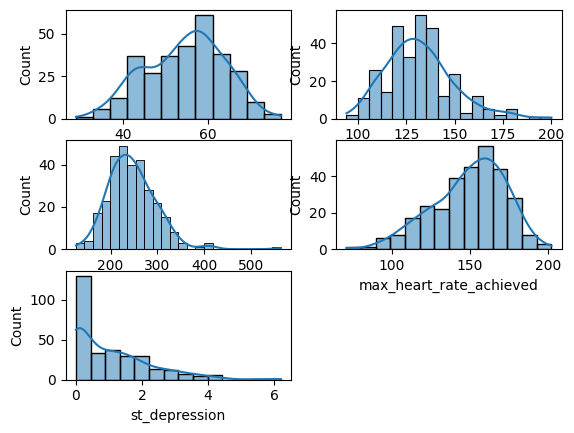

In [100]:
continuous_features
c=1
for i in continuous_features:
    plt.subplot(3,2,c)
    sns.histplot(df[i],kde=True)
    c+=1


- Age (age): The distribution is somewhat uniform, but there's a peak around the late 50s. The mean age is approximately 54.37 years with a standard deviation of 9.08 years.
- Resting Blood Pressure (trestbps): The resting blood pressure for most individuals is concentrated around 120-140 mm Hg, with a mean of approximately 131.62 mm Hg and a standard deviation of 17.54 mm Hg.
- Serum Cholesterol (chol): Most individuals have cholesterol levels between 200 and 300 mg/dl. The mean cholesterol level is around 246.26 mg/dl with a standard deviation of 51.83 mg/dl.
- Maximum Heart Rate Achieved (thalach): The majority of the individuals achieve a heart rate between 140 and 170 bpm during a stress test. The mean heart rate achieved is approximately 149.65 bpm with a standard deviation of 22.91 bpm.
- ST Depression Induced by Exercise (oldpeak): Most of the values are concentrated towards 0, indicating that many individuals did not experience significant ST depression during exercise. The mean ST depression value is 1.04 with a standard deviation of 1.16.

##### Categorical Variables Univariate Analysis

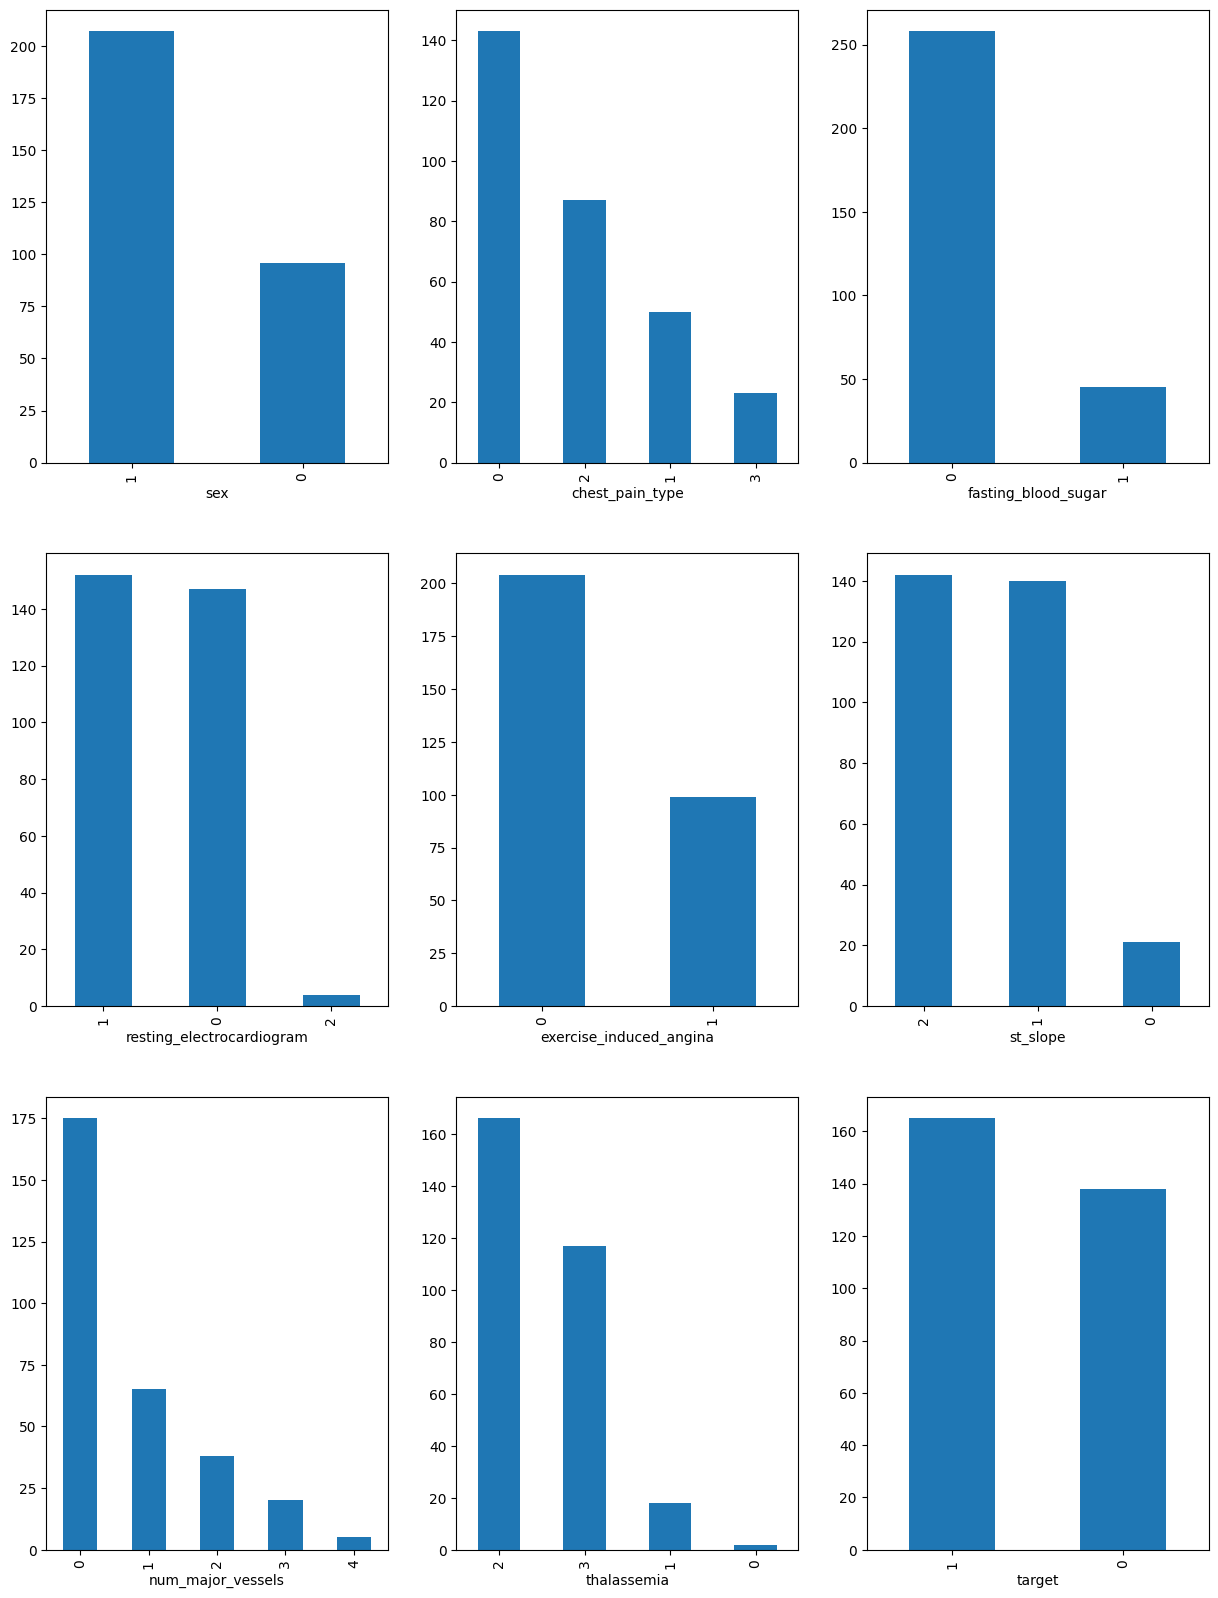

In [101]:
c=1
plt.figure(figsize=(15,20))
for i in features_to_convert:
    plt.subplot(3,3,c)
    df[i].value_counts().sort_values(ascending=False).plot(kind="bar")
    c+=1

- Gender (sex): The dataset is predominantly female, constituting a significant majority.
- Type of Chest Pain (cp): The dataset shows varied chest pain types among patients. Type 0 (Typical angina) seems to be the most prevalent, but an exact distribution among the types can be inferred from the bar plots.
- Fasting Blood Sugar (fbs): A significant majority of the patients have their fasting blood sugar level below 120 mg/dl, indicating that high blood sugar is not a common condition in this dataset.
- Resting Electrocardiographic Results (restecg): The results show varied resting electrocardiographic outcomes, with certain types being more common than others. The exact distribution can be gauged from the plots.
- Exercise-Induced Angina (exang): A majority of the patients do not experience exercise-induced angina, suggesting that it might not be a common symptom among the patients in this dataset.
- Slope of the Peak Exercise ST Segment (slope): The dataset shows different slopes of the peak exercise ST segment. A specific type might be more common, and its distribution can be inferred from the bar plots.
- Number of Major Vessels Colored by Fluoroscopy (ca): Most patients have fewer major vessels colored by fluoroscopy, with '0' being the most frequent.
- Thalium Stress Test Result (thal): The dataset displays a variety of thalium stress test results. One particular type seems to be more prevalent, but the exact distribution can be seen in the plots.
- Presence of Heart Disease (target): The dataset is nearly balanced in terms of heart disease presence, with about 54.5% having it and 45.5% not having it.


##### Bivariate Analysis

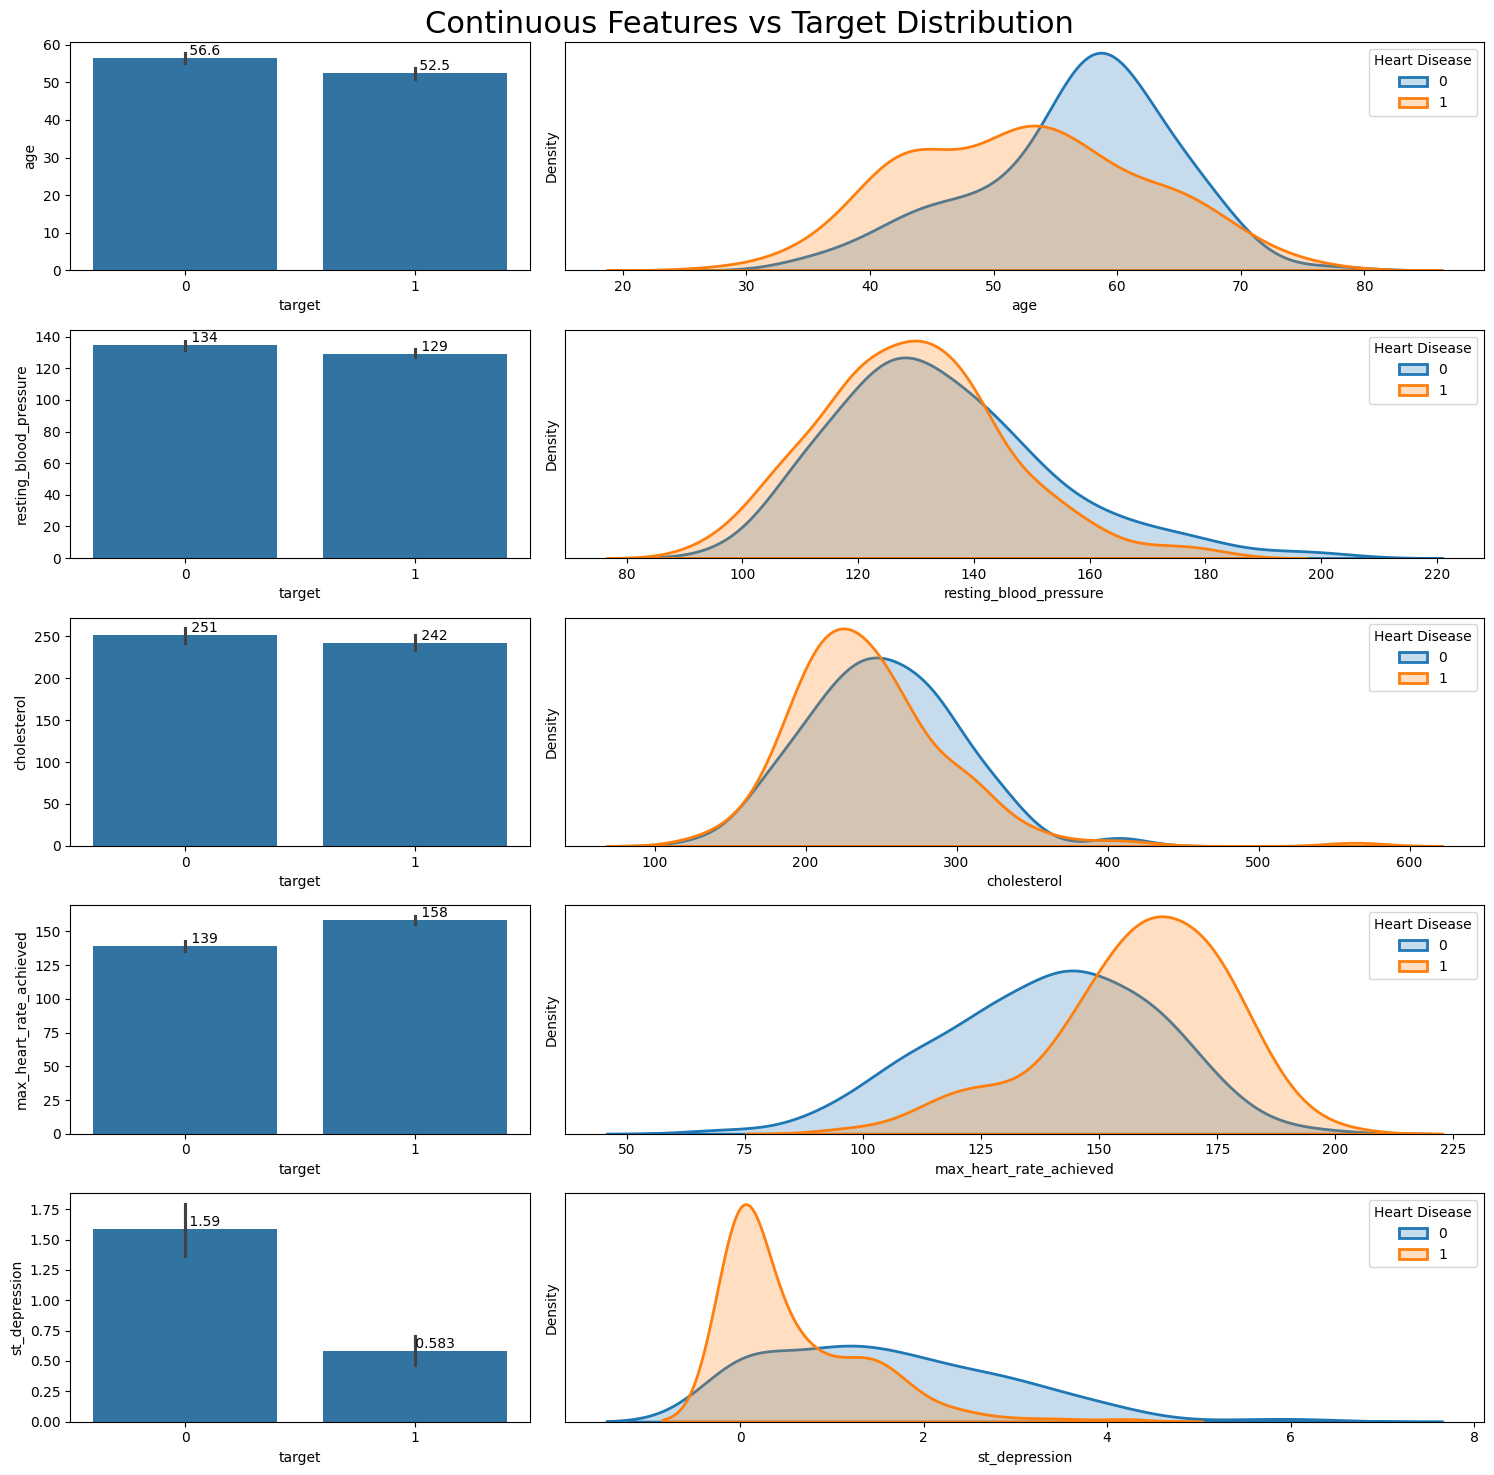

In [102]:
fig, ax = plt.subplots(len(continuous_features), 2, figsize=(15,15), gridspec_kw={'width_ratios': [1, 2]})

# Loop through each continuous feature to create barplots and kde plots
for i, col in enumerate(continuous_features):
    # Barplot showing the mean value of the feature for each target category
    graph = sns.barplot(data=df, x="target", y=col, ax=ax[i,0])
    
    # KDE plot showing the distribution of the feature for each target category
    sns.kdeplot(data=df[df["target"]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df["target"]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Heart Disease', loc='upper right')
    
    # Add mean values to the barplot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')
        
# Set the title for the entire figure
plt.suptitle('Continuous Features vs Target Distribution', fontsize=22)
plt.tight_layout()                     
plt.show()

- Age (age): The distributions show a slight shift with patients having heart disease being a bit younger on average than those without. The mean age for patients without heart disease is higher.
- Resting Blood Pressure (trestbps): Both categories display overlapping distributions in the KDE plot, with nearly identical mean values, indicating limited differentiating power for this feature.
- Serum Cholesterol (chol): The distributions of cholesterol levels for both categories are quite close, but the mean cholesterol level for patients with heart disease is slightly lower.
Maximum Heart Rate Achieved (thalach): There's a noticeable difference in distributions. Patients with heart disease tend to achieve a higher maximum heart rate during stress tests compared to those without.
- ST Depression (oldpeak): The ST depression induced by exercise relative to rest is notably lower for patients with heart disease. Their distribution peaks near zero, whereas the non-disease category has a wider spread.

Based on the visual difference in distributions and mean values, Maximum Heart Rate (thalach) seems to have the most impact on the heart disease status, followed by ST Depression (oldpeak) and Age (age).

##### Categorical Features vs Target

In [103]:
cross_tab=pd.crosstab(index=df["thalassemia"],columns=df["target"],normalize="index") 

In [104]:
cross_tab

target,0,1
thalassemia,,
0,0.500000,0.500000
1,0.666667,0.333333
2,0.216867,0.783133
3,0.760684,0.239316


<Axes: xlabel='thalassemia'>

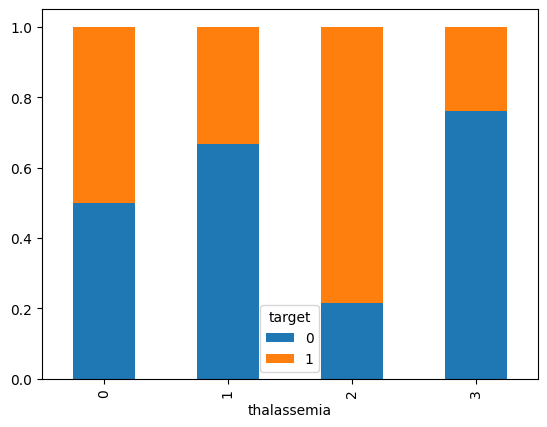

In [105]:
cross_tab.plot(kind='bar',stacked=True)

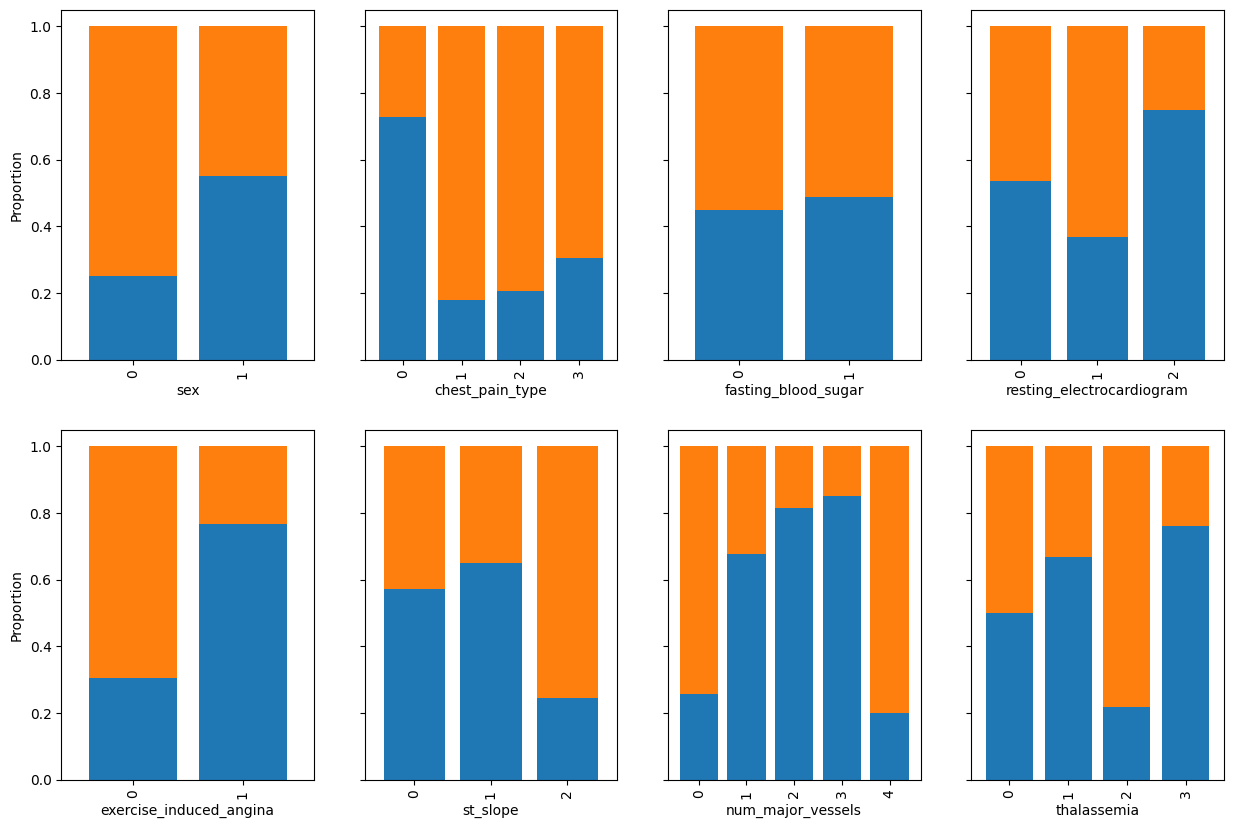

In [106]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,10))

for i,col in enumerate(features_to_convert):
    
    # Create a cross tabulation showing the proportion of purchased and non-purchased loans for each category of the feature
    cross_tab = pd.crosstab(index=df[col], columns=df['target'])
    
    # Using the normalize=index argument gives us the index-wise proportion of the data
    cross_tab_prop = pd.crosstab(index=df[col], columns=df['target'], normalize='index')
    # Plot stacked bar charts
    x, y = i//4, i%4

    if col !="target":
        cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, 
                        legend=False, ylabel='Proportion', sharey=True)

- Number of Major Vessels (ca): The majority of patients with heart disease have fewer major vessels colored by fluoroscopy. As the number of colored vessels increases, the proportion of patients with heart disease tends to decrease. Especially, patients with 0 vessels colored have a higher proportion of heart disease presence.
- Chest Pain Type (cp): Different types of chest pain present varied proportions of heart disease. Notably, types 1, 2, and 3 have a higher proportion of heart disease presence compared to type 0. This suggests the type of chest pain can be influential in predicting the disease.
- Exercise Induced Angina (exang): Patients who did not experience exercise-induced angina (0) show a higher proportion of heart disease presence compared to those who did (1). This feature seems to have a significant impact on the target.
- Fasting Blood Sugar (fbs): The distribution between those with fasting blood sugar > 120 mg/dl (1) and those without (0) is relatively similar, suggesting fbs might have limited impact on heart disease prediction.
- Resting Electrocardiographic Results (restecg): Type 1 displays a higher proportion of heart disease presence, indicating that this feature might have some influence on the outcome.
- Sex (sex): Females (1) exhibit a lower proportion of heart disease presence compared to males (0). This indicates gender as an influential factor in predicting heart disease.
- Slope of the Peak Exercise ST Segment (slope): The slope type 2 has a notably higher proportion of heart disease presence, indicating its potential as a significant predictor.
- Thalium Stress Test Result (thal): The reversible defect category (2) has a higher proportion of heart disease presence compared to the other categories, emphasizing its importance in prediction.
In summary, based on the visual representation:

Higher Impact on Target: ca, cp, exang, sex, slope, and thal
Moderate Impact on Target: restecg
Lower Impact on Target: fbs

# Data Preprocessing

### Missing value treatment

In [107]:
df.isnull().sum()

age                          0
sex                          0
chest_pain_type              0
resting_blood_pressure       0
cholesterol                  0
fasting_blood_sugar          0
resting_electrocardiogram    0
max_heart_rate_achieved      0
exercise_induced_angina      0
st_depression                0
st_slope                     0
num_major_vessels            0
thalassemia                  0
target                       0
dtype: int64

### Outlier detection

In [108]:
continuous_features

['age',
 'resting_blood_pressure',
 'cholesterol',
 'max_heart_rate_achieved',
 'st_depression']

In [109]:
df[continuous_features].quantile(0.25)

age                         47.5
resting_blood_pressure     120.0
cholesterol                211.0
max_heart_rate_achieved    133.5
st_depression                0.0
Name: 0.25, dtype: float64

In [110]:
q1=df[continuous_features].quantile(0.25)
q3=df[continuous_features].quantile(0.75)

IQR=q3-q1
outliers_count_specified =((df[continuous_features] < (q1-1.5*IQR)) | (df[continuous_features] > q3 + 1.5*IQR)).sum()
outliers_count_specified 

age                        0
resting_blood_pressure     9
cholesterol                5
max_heart_rate_achieved    1
st_depression              5
dtype: int64

Approaches for Outlier Treatment:
- Removal of Outliers: Directly discard data points that fall outside of a defined range, typically based on a method like the Interquartile Range (IQR).
- Capping Outliers: Instead of removing, we can limit outliers to a certain threshold, such as the 1st or 99th percentile.
- Transformations: Applying transformations like log or Box-Cox can reduce the impact of outliers and make the data more Gaussian-like.
- Robust Scaling: Techniques like the RobustScaler in Scikit-learn can be used, which scales features using statistics that are robust to outliers.

### Feature Encoding

- sex: This is a binary variable with two categories (male and female), so it doesn't need one-hot encoding.
- cp: Chest pain type can be considered as nominal because there's no clear ordinal relationship among the different types of chest pain (like Typical angina, Atypical angina, etc.). It should be one-hot encoded.
- fbs: This is a binary variable (true or false), so it doesn't need one-hot encoding.
- restecg: This variable represents the resting electrocardiographic results. The results, such as "Normal", "Having ST-T wave abnormality", and "Showing probable or definite left ventricular hypertrophy", don't seem to have an ordinal relationship. Therefore, it should be one-hot encoded.
- exang: This is a binary variable (yes or no), so it doesn't need one-hot encoding.
- slope: This represents the slope of the peak exercise ST segment. Given the descriptions (Upsloping, Flat, Downsloping), it seems to have an ordinal nature, suggesting a particular order. Therefore, it doesn't need to be one-hot encoded.
- ca: This represents the number of major vessels colored by fluoroscopy. As it indicates a count, it has an inherent ordinal relationship. Therefore, it doesn't need to be one-hot encoded.
- thal: This variable represents the result of a thalium stress test. The different states, like "Normal", "Fixed defect", and "Reversible defect", suggest a nominal nature. Thus, it should be 
one-hot encoded.

Summary:
- Need One-Hot Encoding: cp, restecg, thal
- Don't Need One-Hot Encoding: sex, fbs, exang, slope, ca

In [111]:
one_hot_col=['chest_pain_type', 'resting_electrocardiogram', 'thalassemia',"st_slope","num_major_vessels"]

for i in one_hot_col:
    for sub_cat in df[i].unique():
        df[i + str(sub_cat)]=df[i].apply(lambda x: 1 if x==sub_cat else 0)

In [112]:
## we we converted one_hot_col to one hot encoding we dont need them

df.drop(one_hot_col,axis=1,inplace=True)

In [113]:
## converting below to int datatype
features_to_convert=['sex', 'fasting_blood_sugar', 'exercise_induced_angina', 'target']

for i in features_to_convert:
    df[i]=df[i].astype("int")

In [114]:
df.dtypes

age                             int64
sex                             int32
resting_blood_pressure          int64
cholesterol                     int64
fasting_blood_sugar             int32
max_heart_rate_achieved         int64
exercise_induced_angina         int32
st_depression                 float64
target                          int32
chest_pain_type3                int64
chest_pain_type2                int64
chest_pain_type1                int64
chest_pain_type0                int64
resting_electrocardiogram0      int64
resting_electrocardiogram1      int64
resting_electrocardiogram2      int64
thalassemia1                    int64
thalassemia2                    int64
thalassemia3                    int64
thalassemia0                    int64
st_slope0                       int64
st_slope2                       int64
st_slope1                       int64
num_major_vessels0              int64
num_major_vessels2              int64
num_major_vessels1              int64
num_major_ve

In [115]:
df.head()

,age,sex,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,target,chest_pain_type3,...,thalassemia3,thalassemia0,st_slope0,st_slope2,st_slope1,num_major_vessels0,num_major_vessels2,num_major_vessels1,num_major_vessels3,num_major_vessels4
0,63,1,145,233,1,150,0,2.3,1,1,...,0,0,1,0,0,1,0,0,0,0
1,37,1,130,250,0,187,0,3.5,1,0,...,0,0,1,0,0,1,0,0,0,0
2,41,0,130,204,0,172,0,1.4,1,0,...,0,0,0,1,0,1,0,0,0,0
3,56,1,120,236,0,178,0,0.8,1,0,...,0,0,0,1,0,1,0,0,0,0
4,57,0,120,354,0,163,1,0.6,1,0,...,0,0,0,1,0,1,0,0,0,0


In [116]:
df_copy=df.copy()

ValueError: Data must be positive.

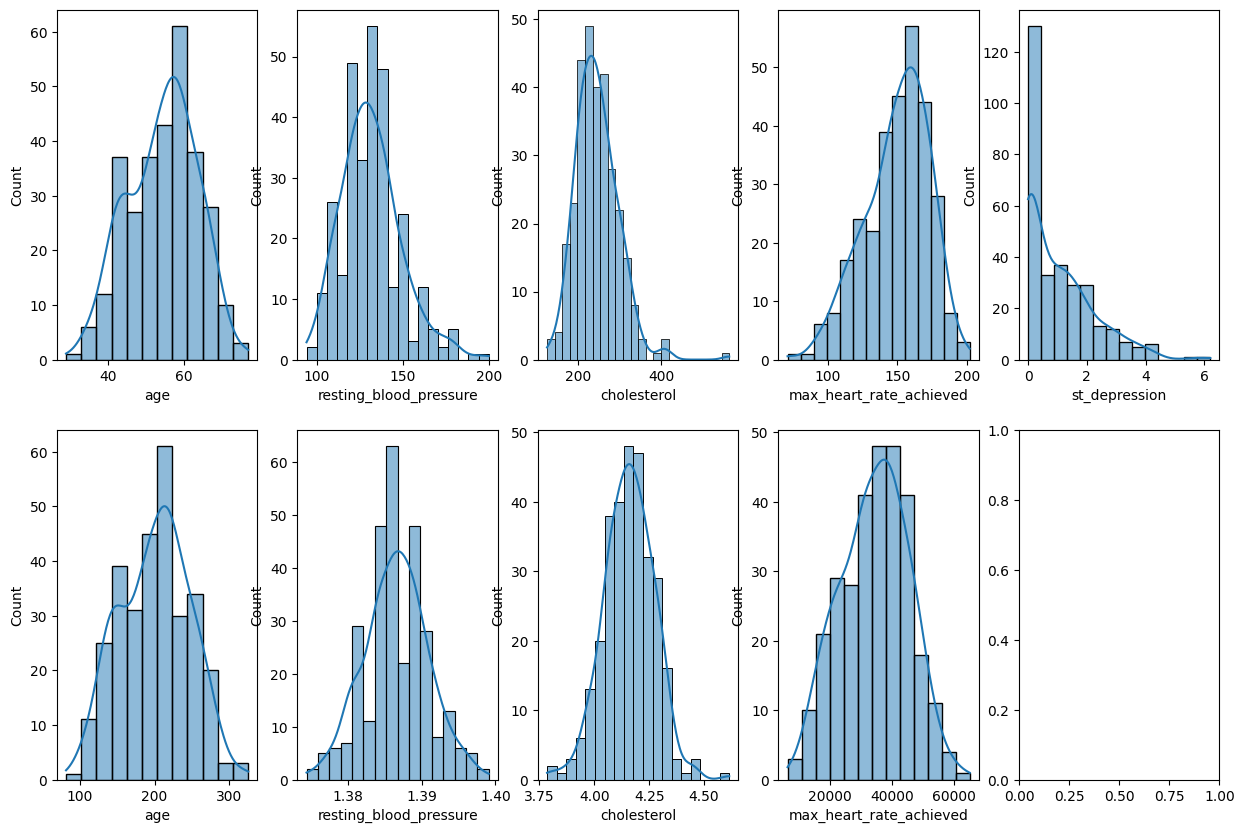

In [117]:
cont_var=["age","resting_blood_pressure","cholesterol","max_heart_rate_achieved","st_depression"]

fig,ax=plt.subplots(2,5,figsize=(15,10))

for i,col in enumerate(cont_var):
    sns.histplot(df_copy[col],ax=ax[0,i],kde=True)

#with boxcox
for i,col in enumerate(cont_var):
    df_copy[col],lbda=boxcox(df_copy[col])
    sns.histplot(df_copy[col],ax=ax[1,i],kde=True)

### Model Building

In [127]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
X=df.drop("target",axis=1)
y=df["target"]

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.2)

In [118]:
scaler=StandardScaler()

x_train[cont_var]=scaler.fit_transform(x_train[cont_var])
x_test[cont_var]=scaler.transform(x_test[cont_var])

In [119]:
x_train

,age,sex,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,...,chest_pain_type2,chest_pain_type1,chest_pain_type0,resting_electrocardiogram0,resting_electrocardiogram1,resting_electrocardiogram2,thalassemia1,thalassemia2,thalassemia3,thalassemia0
132,-1.356798,1,-0.616856,0.914034,0,0.532781,0,-0.920864,2,0,...,0,1,0,0,1,0,0,1,0,0
202,0.385086,1,1.169491,0.439527,0,-1.753582,1,-0.193787,2,0,...,0,0,1,1,0,0,0,0,1,0
196,-0.921327,1,1.169491,-0.300704,0,-0.139679,0,2.350982,1,0,...,1,0,0,0,1,0,0,1,0,0
75,0.058483,0,0.276318,0.059921,0,0.487950,0,0.351521,1,0,...,0,1,0,1,0,0,0,1,0,0
176,0.602822,1,-0.795490,-0.319684,1,0.443119,1,0.351521,2,2,...,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,-0.485856,1,0.574042,-0.262744,0,0.577611,0,-0.375556,1,1,...,1,0,0,0,1,0,0,0,1,0
71,-0.376988,1,-2.165023,-0.376625,0,0.174136,1,-0.920864,2,1,...,1,0,0,0,1,0,0,0,1,0
106,1.582631,1,1.764940,-0.243763,1,-0.856969,0,-0.829979,1,1,...,0,0,0,1,0,0,0,1,0,0
270,-0.921327,1,-0.616856,0.040941,0,-0.274171,0,-0.193787,2,0,...,0,0,1,1,0,0,0,0,1,0


In [123]:
def train_model(model):
    model.fit(x_train,y_train)
    y_train_pred=model.predict(x_train)
    y_test_pred=model.predict(x_test)
    training_report=classification_report(y_train_pred,y_train)
    test_report=classification_report(y_test_pred,y_test)
    print(f"Training Report \n {training_report}")
    print(f"Test report \n {test_report}")

In [124]:
dtc=DecisionTreeClassifier()
train_model(dtc)

Training Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       1.00      1.00      1.00       133

    accuracy                           1.00       242
   macro avg       1.00      1.00      1.00       242
weighted avg       1.00      1.00      1.00       242

Test report 
               precision    recall  f1-score   support

           0       0.83      0.83      0.83        29
           1       0.84      0.84      0.84        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



In [125]:
rfc=RandomForestClassifier()
train_model(rfc)

Training Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       1.00      1.00      1.00       133

    accuracy                           1.00       242
   macro avg       1.00      1.00      1.00       242
weighted avg       1.00      1.00      1.00       242

Test report 
               precision    recall  f1-score   support

           0       0.83      0.80      0.81        30
           1       0.81      0.84      0.83        31

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61



In [126]:
svm=SVC()
train_model(svm)

Training Report 
               precision    recall  f1-score   support

           0       0.86      0.93      0.90       101
           1       0.95      0.89      0.92       141

    accuracy                           0.91       242
   macro avg       0.90      0.91      0.91       242
weighted avg       0.91      0.91      0.91       242

Test report 
               precision    recall  f1-score   support

           0       0.86      0.86      0.86        29
           1       0.88      0.88      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



In [128]:
knn=KNeighborsClassifier()
train_model(knn)

Training Report 
               precision    recall  f1-score   support

           0       0.84      0.87      0.86       106
           1       0.89      0.88      0.88       136

    accuracy                           0.87       242
   macro avg       0.87      0.87      0.87       242
weighted avg       0.87      0.87      0.87       242

Test report 
               precision    recall  f1-score   support

           0       0.86      0.81      0.83        31
           1       0.81      0.87      0.84        30

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61

